In [34]:
import pandas as pd
from src.models.embeddings import MeanEmbeddingVectorizer

In [9]:
df_aug_scibert = pd.read_csv("../data/train_aug_scibert.txt", sep=',',header=None)

In [7]:
df_aug_scibert

,0,1
0,1,the planned extension studies ct - p10 3. 8 2 ...
1,1,"so for these 13 parameters, chf patients 5993 ..."
2,1,vs no significant or additional benefit was ob...
3,2,given the consistency among measurements the v...
4,1,"1 ). 3 nevertheless, the applicant fda has con..."
...,...,...
181,2,"seg furthermore, data mea in spms patients wit..."
182,1,most quantitatively common frequently reported...
183,2,overall biosimilarity completion of ct - p10 f...
184,2,safety and tolerability results of fasting ins...


In [10]:
df_aug_bt = pd.read_csv("../data/train_aug_bt.txt", sep=',',header=None)

In [15]:
print(df_aug_bt[1][10])
print(df_aug_scibert[1][10])

This risk is adequately treated in various areas of the SmPC and identified as an important identified risk in the RMP.
this single risk is adequately addressed again in a various clinical sections of the smpc but and as some important identified risk in the control rmp.


Read in the GPT augmented data, this includes the original sentences

In [16]:
df_aug_gpt = pd.read_csv("../data/train_augmented-gpt.csv")

In [17]:
df_aug_gpt.drop_duplicates

,Unnamed: 0,Sentence,Augmentation,Polarity
0,0,No significant additional benefit was observed...,0,1
1,1,the study showed that the 300 mg dose of omari...,1,1
2,2,The study also showed that the 300 mg dose was...,1,1
3,3,The consistency among the various key clinical...,0,2
4,4,the drug is effective in both the pre-symptoma...,1,2
...,...,...,...,...
538,538,the insulin lispro biosimilar is as safe and e...,1,2
539,539,"The study was a randomized, open-label, active...",1,2
540,540,"Therefore, the available safety data are consi...",0,2
541,541,the data are not sufficient to conclude that C...,1,2


In [19]:
df = pd.concat([df_aug_bt,df_aug_scibert], ignore_index=True)

In [22]:
df = df.rename(columns={0:'Polarity', 1: 'Sentence'})

In [24]:
df['Augmentation'] = 1

In [25]:
df

,Polarity,Sentence,Augmentation
0,1,The planned CT-P10 3.2 (RA) CT-P10 3.3 (AFL) a...,1
1,1,CHF 5993 pMDI and Foster pMDI + tiotropium gen...,1
2,1,At weekly dosage compared to Q2W dosage (300 m...,1
3,2,The consistency between the various clinically...,1
4,1,"1). Nevertheless, the applicant has conducted ...",1
...,...,...,...
367,2,"seg furthermore, data mea in spms patients wit...",1
368,1,most quantitatively common frequently reported...,1
369,2,overall biosimilarity completion of ct - p10 f...,1
370,2,safety and tolerability results of fasting ins...,1


In [27]:
train_df = pd.concat([df_aug_gpt, df], ignore_index=True)

,Sentence,Augmentation,Polarity
0,No significant additional benefit was observed...,0,1
1,the study showed that the 300 mg dose of omari...,1,1
2,The study also showed that the 300 mg dose was...,1,1
3,The consistency among the various key clinical...,0,2
4,the drug is effective in both the pre-symptoma...,1,2
...,...,...,...
910,"seg furthermore, data mea in spms patients wit...",1,2
911,most quantitatively common frequently reported...,1,1
912,overall biosimilarity completion of ct - p10 f...,1,2
913,safety and tolerability results of fasting ins...,1,2


In [62]:
from nltk.corpus import stopwords
global stopword_set 
stopword_set = set(stopwords.words('english'))
modals_set = {'can', 'could', 'may', 'might', 'must', 'will', 'would', 'should', 'not'}
# for this application we do not want to remove modals as they might carry polarity signals
stopword_set.difference_update(modals_set)

In [68]:
from typing import Set
def remove_stopwords(text:str, stopwords:Set) -> str:
    processed_list = [word for word in text.split() if word not in stopwords] 
    return ' '.join(processed_list)

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except the modals and not
    - Remove trailing whitespace
    """
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = remove_stopwords(s, stopword_set)
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    # Uncomment to lemmatize as well
#     s = lemmatize(s) 
    
    return s

In [104]:
from gensim.models import Word2Vec, KeyedVectors
from nltk import word_tokenize


word2vec_path = '../models/bio_embedding_extrinsic'
w2v_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
mev = MeanEmbeddingVectorizer(w2v_model)
tp = TextProcessor()

train_df["Sentence_swf"] = train_df["Sentence"].apply(lambda s: text_preprocessing(s))

y = list(train_df["Polarity"])
X_tok= [word_tokenize(i) for i in train_df["Sentence_swf"]]  #for word2vec
X = mev.transform(X_tok)


Optimal number of features : 119


/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


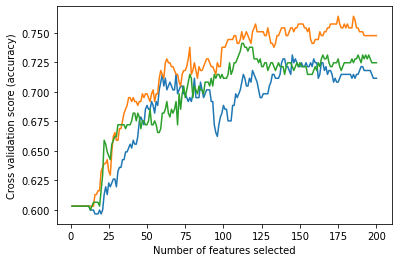

In [71]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV# Create the RFE object and compute a cross-validated score.

svc = SVC(kernel="linear")
# The "accuracy" scoring shows the proportion of correct classifications

min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=StratifiedKFold(3,random_state=42,shuffle=True),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)

rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

In [89]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC


# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, np.array(y), test_size=0.2, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

scores = ["precision", "recall"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision



/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.209 (+/-0.002) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.209 (+/-0.002) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.209 (+/-0.002) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.209 (+/-0.002) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.209 (+/-0.002) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.209 (+/-0.002) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.740 (+/-0.050) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.209 (+/-0.002) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.731 (+/-0.072) for {'C': 1, 'kernel': 'linear'}
0.736 (+/-0.064) for {'C': 10, 'kernel': 'linear'}
0.711 (+/-0.053) for {'C': 100, 'kernel': 'linear'}
0.701 (+/-0.045) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

           

### How does it do on the actual test data we set aside?

In [38]:
text_file = open("../data/labels_test.txt")
test_labels = text_file.read().split('\n')

In [92]:
text_file = open("../data/test.txt")
test_sentences = text_file.read().split('\n')

In [94]:
test_sentences[0:2]

['In the HCV GT1-infected population (the most widely represented in the EU) the observed results -with 99% SVR12 achieved with a convenient 8 weeks treatment duration in non-cirrhotic TN or TE-PRS patients and 97% in cirrhotic patients with a 12 weeks treatment duration- support the fact that this FDC will represent an optimization in the therapeutic armamentarium. ',
 'The effect was consistent across studies and across investigated subgroups.']

In [95]:
test_labels[0:2]

['2', '1']

In [108]:
X_test_tok= [word_tokenize(text_preprocessing(sent)) for sent in test_sentences]  #for word2vec
X_test = mev.transform(X_test_tok)

In [106]:
test_labels = list(map(int, test_labels))

In [103]:
y_true, y_pred = test_labels, clf.predict(X)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.64      0.54        11
           1       0.44      0.33      0.38        21
           2       0.73      0.75      0.74        48

    accuracy                           0.62        80
   macro avg       0.55      0.57      0.55        80
weighted avg       0.62      0.62      0.62        80



In [113]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC


# This time lets use the hold out test for tuning 
# X, y, X_test, y_test

# Set the parameters by cross-validation
tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

scores = ["precision", "recall"]

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_["mean_test_score"]
    stds = clf.cv_results_["std_test_score"]
    for mean, std, params in zip(means, stds, clf.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = test_labels, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


# Tuning hyper-parameters for precision



/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/shm/Projects/DS_NLP_Assignment/biomed-sentiment/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.201 (+/-0.002) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.201 (+/-0.002) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.201 (+/-0.002) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.201 (+/-0.002) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.546 (+/-0.196) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.201 (+/-0.002) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.736 (+/-0.232) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.547 (+/-0.196) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.732 (+/-0.211) for {'C': 1, 'kernel': 'linear'}
0.738 (+/-0.184) for {'C': 10, 'kernel': 'linear'}
0.704 (+/-0.142) for {'C': 100, 'kernel': 'linear'}
0.660 (+/-0.123) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision   

In [119]:
y_true_train , y_pred_train = y, clf.predict(X)
print(classification_report(y_true_train, y_pred_train))


              precision    recall  f1-score   support

           0       0.94      0.97      0.95       125
           1       0.94      0.92      0.93       238
           2       0.96      0.97      0.96       552

    accuracy                           0.95       915
   macro avg       0.95      0.95      0.95       915
weighted avg       0.95      0.95      0.95       915



As we are still overfitting, maybe feature engineering for presence of certain phrases would be the way to improve